→ A | warning: glm.fit: fitted probabilities numerically 0 or 1 occurred

There were issues with some computations   A: x1

There were issues with some computations   A: x1





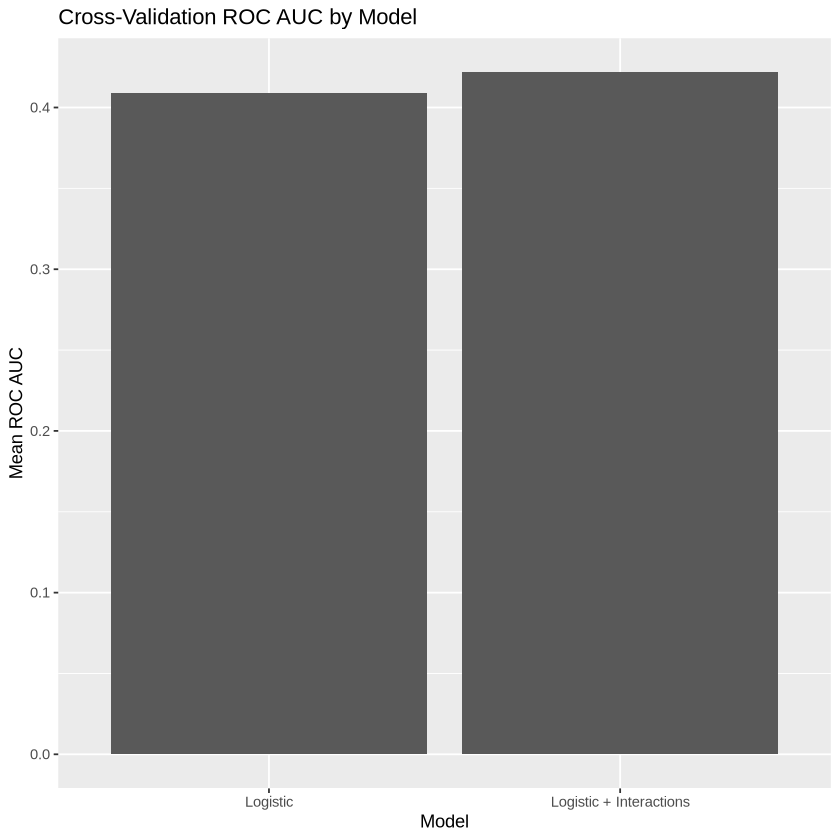

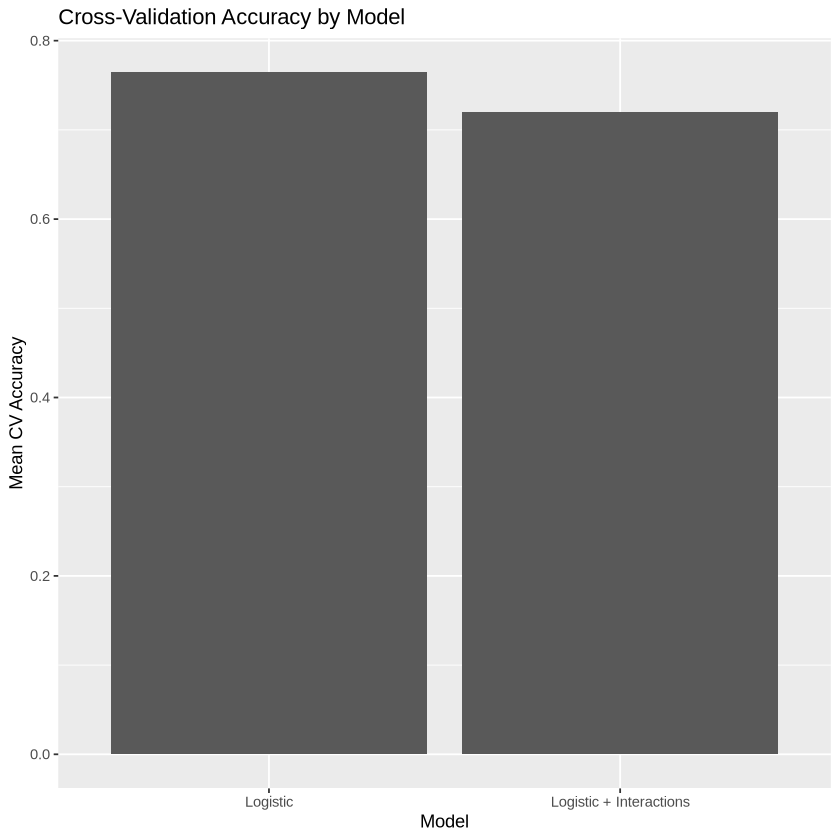

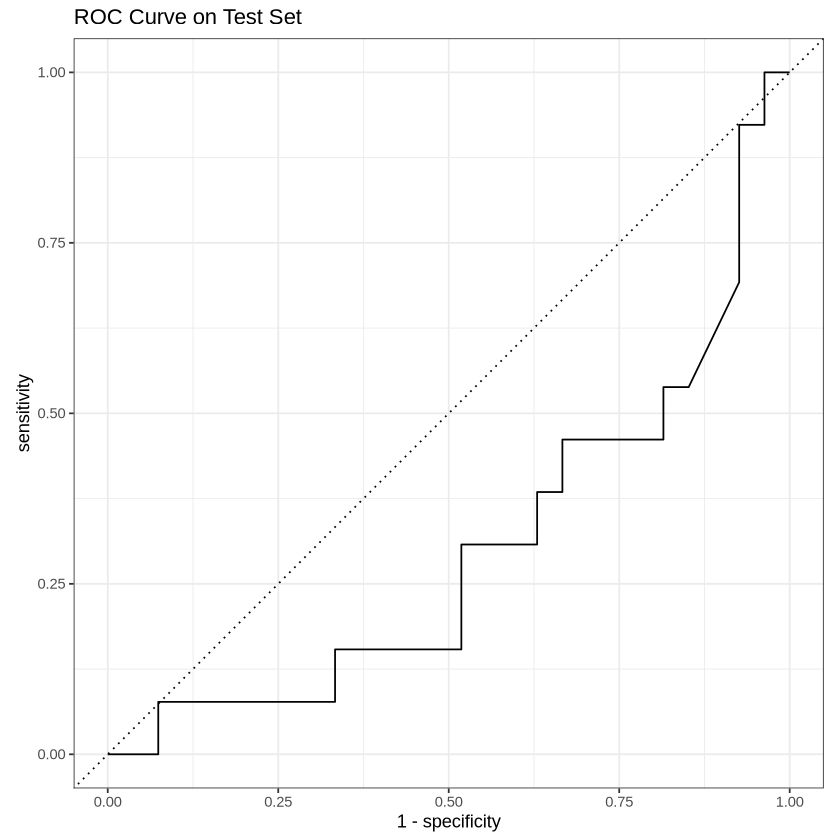

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


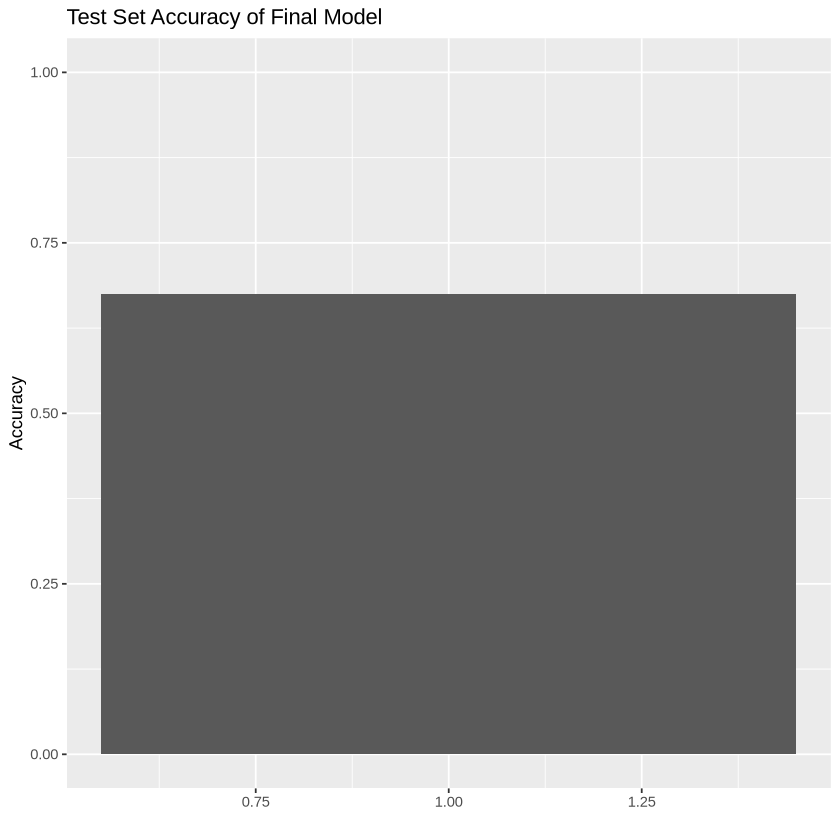

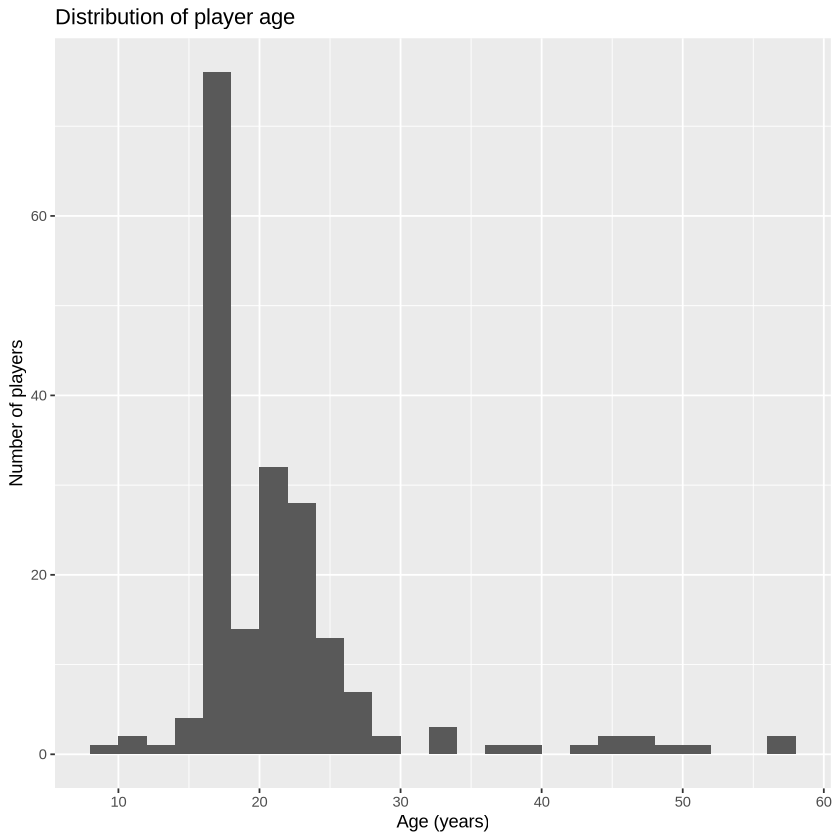

Warning message:
“Removed 71 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


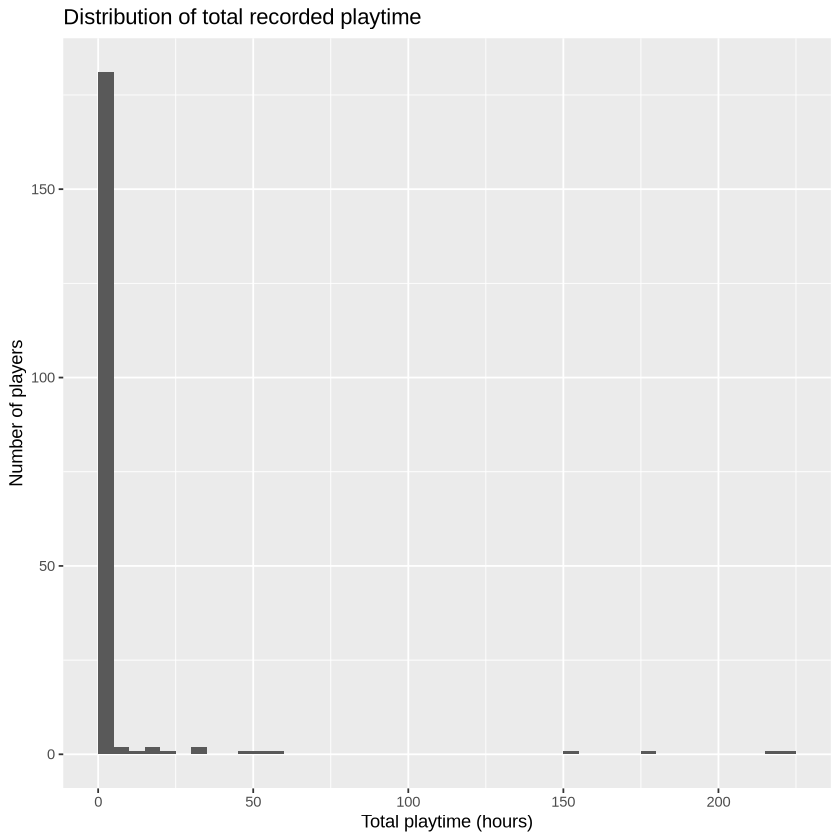

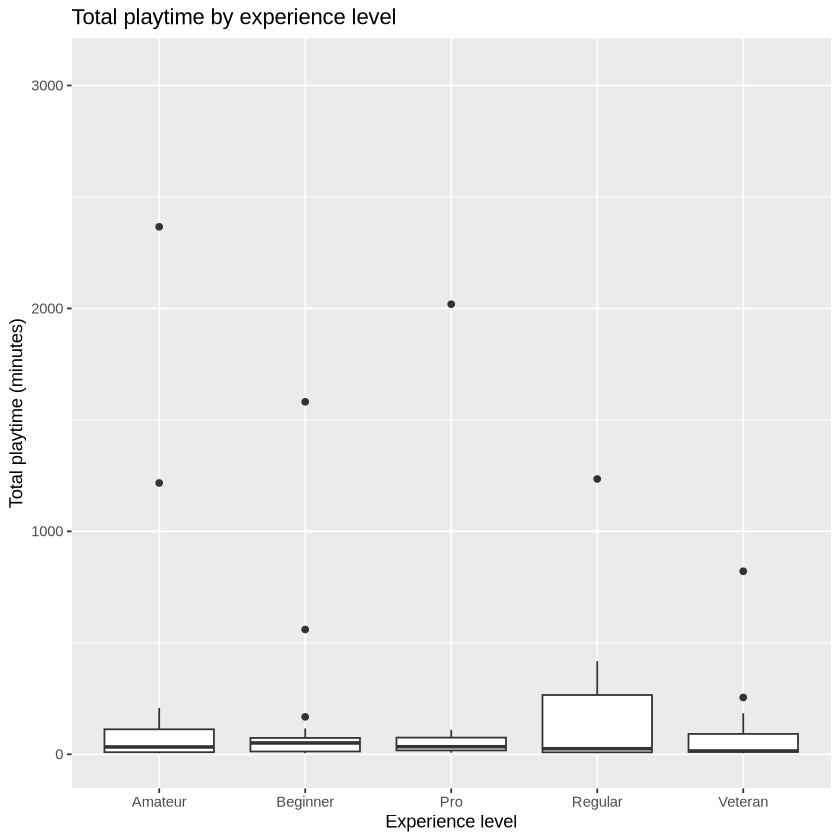

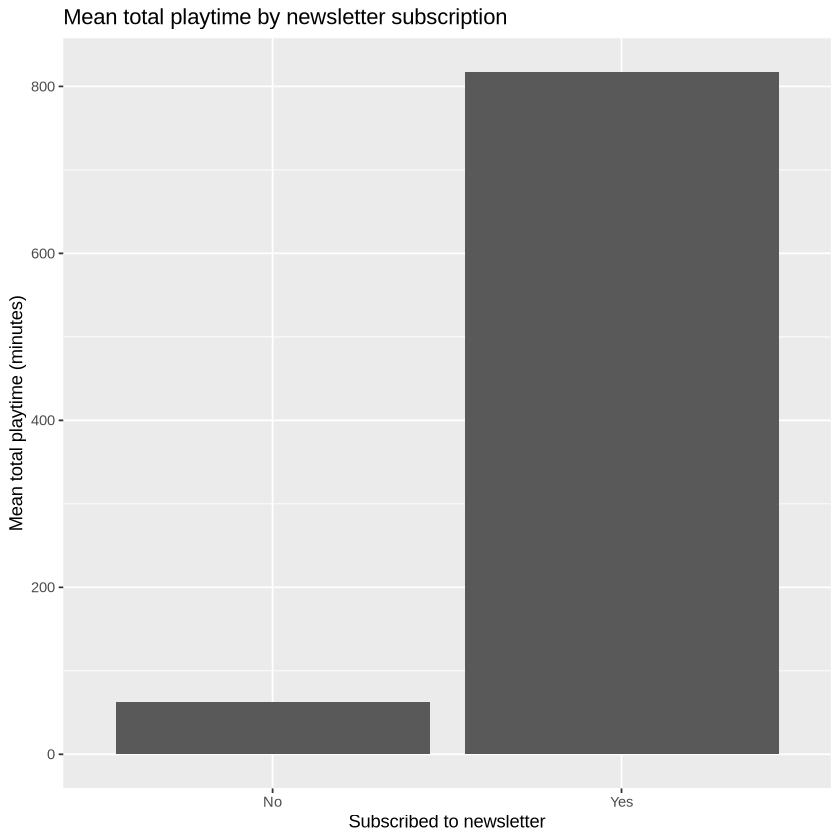

In [12]:
library(tidyverse)
library(lubridate)
library(tidymodels)

set.seed(123)

players <- read_csv("players.csv", show_col_types = FALSE)
sessions <- read_csv("sessions.csv", show_col_types = FALSE)

sessions_tidy <- sessions |>
  mutate(
    start_dt = dmy_hm(start_time),
    end_dt = dmy_hm(end_time),
    session_minutes = as.numeric(difftime(end_dt, start_dt, units = "mins"))
  )

sessions_player <- sessions_tidy |>
  filter(!is.na(session_minutes)) |>
  group_by(hashedEmail) |>
  summarise(
    total_playtime_min = sum(session_minutes),
    avg_session_min = mean(session_minutes),
    session_count = n(),
    .groups = "drop"
  )

players_full <- players |>
  left_join(sessions_player, by = "hashedEmail") |>
  mutate(
    played_hours = total_playtime_min / 60,
    subscribe = factor(if_else(subscribe, "Yes", "No"), levels = c("No","Yes"))
  )

players_model <- players_full |>
  filter(!is.na(subscribe)) |>
  select(subscribe, Age, total_playtime_min, avg_session_min, session_count) |>
  mutate(
    log_playtime = log1p(total_playtime_min)
  )

split <- initial_split(players_model, prop = 0.7)
train <- training(split)
test <- testing(split)

cv_folds <- vfold_cv(train, v = 5)

baseline_recipe <- recipe(subscribe ~ Age + log_playtime + avg_session_min + session_count, data = train) |>
  step_zv() |>
  step_normalize(all_numeric_predictors())

interaction_recipe <- recipe(subscribe ~ Age + log_playtime + avg_session_min + session_count, data = train) |>
  step_zv() |>
  step_normalize(all_numeric_predictors()) |>
  step_interact(terms = ~ Age:log_playtime)

logistic_model <- logistic_reg() |> set_engine("glm")
logistic_interact_model <- logistic_reg() |> set_engine("glm")

baseline_workflow <- workflow() |> add_recipe(baseline_recipe) |> add_model(logistic_model)
interaction_workflow <- workflow() |> add_recipe(interaction_recipe) |> add_model(logistic_interact_model)

baseline_res <- baseline_workflow |> fit_resamples(
  cv_folds,
  metrics = metric_set(roc_auc, accuracy),
  control = control_resamples()
)

interaction_res <- interaction_workflow |> fit_resamples(
  cv_folds,
  metrics = metric_set(roc_auc, accuracy),
  control = control_resamples()
)

baseline_metrics <- baseline_res |> collect_metrics() |> mutate(model = "Logistic")
interaction_metrics <- interaction_res |> collect_metrics() |> mutate(model = "Logistic + Interactions")
all_cv <- bind_rows(baseline_metrics, interaction_metrics)

ggplot(all_cv |> filter(.metric == "roc_auc"), aes(x = model, y = mean)) +
  geom_col() +
  labs(title = "Cross-Validation ROC AUC by Model", x = "Model", y = "Mean ROC AUC")

ggplot(all_cv |> filter(.metric == "accuracy"), aes(x = model, y = mean)) +
  geom_col() +
  labs(title = "Cross-Validation Accuracy by Model", x = "Model", y = "Mean CV Accuracy")

final_workflow <- baseline_workflow |> fit(train)
test_results <- final_workflow |> predict(test, type = "prob") |> bind_cols(test)

roc_curve_data <- roc_curve(test_results, truth = subscribe, .pred_Yes)
autoplot(roc_curve_data) + labs(title = "ROC Curve on Test Set")

test_results <- test_results |> mutate(pred_class = factor(.pred_Yes > 0.5, levels = c(FALSE, TRUE), labels = c("No", "Yes")))
test_accuracy <- test_results |> accuracy(truth = subscribe, estimate = pred_class)

ggplot(test_accuracy, aes(x = 1, y = .estimate)) +
  geom_col() +
  labs(title = "Test Set Accuracy of Final Model", x = "", y = "Accuracy") +
  ylim(0, 1)

#  histogram of Age
ggplot(players, aes(x = Age)) +
  geom_histogram(binwidth = 2, boundary = 0, closed = "left") +
  labs( title = "Distribution of player age", x = "Age (years)", y = "Number of players" )

# Histogram of played_hours
ggplot(players, aes(x = played_hours)) +
  geom_histogram(binwidth = 5, boundary = 0, closed = "left") +
  labs( title = "Distribution of total recorded playtime", x = "Total playtime (hours)", y = "Number of players" )

# boxplot of total_playtime_min by experience
ggplot(players_full, aes(x = experience, y = total_playtime_min)) +
  geom_boxplot() +
  coord_cartesian(
    ylim = c( 0, quantile(players_full$total_playtime_min, 0.95, na.rm = TRUE) ) ) +
  labs(title = "Total playtime by experience level", x = "Experience level", y = "Total playtime (minutes)" )

# Bar chart of mean total_playtime_min by subscribe
players_full |>
  group_by(subscribe) |>
  summarise(
    mean_total_playtime_min = mean(total_playtime_min, na.rm = TRUE), .groups = "drop") |> 
ggplot(aes(x = subscribe, y = mean_total_playtime_min)) +
  geom_col() +
  labs( title = "Mean total playtime by newsletter subscription", x = "Subscribed to newsletter", y = "Mean total playtime (minutes)" )

     